In [2]:
import numpy as np # 계산을 위해 행렬과 같은 다양한 수학 도구를 사용하기 위한 라이브러리
import os
import pandas as pd
import random

#Machine Learning Library
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle           

#Plotting Libraries
import seaborn as sn; sn.set(font_scale=1.4)
import matplotlib.pyplot as plt             

#openCV
import cv2                                 

#Tensor Flow & Keras
import tensorflow as tf    
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

#Train & Test Data Split
from sklearn.model_selection import train_test_split

#Garbage Collector
import gc





from keras.callbacks import EarlyStopping, ModelCheckpoint


Using TensorFlow backend.


In [3]:
from PIL import Image # Python Image Library  (파이썬을 이용해서 쉽게 이미지 프로세싱을 할 수 있게 주는 라이브러리)

import numpy as np # 계산을 위해 행렬과 같은 다양한 수학 도구를 사용하기 위한 라이브러리
import os # OS는 operating system의 약자로, 운영체제를 의미 파이썬에 기본적으로 내장된 모듈의 이름
           # os.path 모듈은 파일명과 파일경로에 대한 유용한 함수들을 많이 제공함
            # 경로의 이미지를 모두 뽑아내기 위한 os.listdir 사용예제
        
import glob # 재귀적으로 현재 폴더의 모든 하위폴더까지 탐색하여 확장자가 jpg인 파일을 출력한다.
            # 특정 파일만 출력하기
#openCV
import cv2   
    


from sklearn.model_selection import train_test_split

caltech_dir = "dataset/train" # fire 데이터 폴더 경로
categories = ["neutral","angry","surprise","smile","sad"]  # 각 dataset 폴더이름
nb_classes = len(categories)

image_w = 48
image_h = 48

X = []
y = []

for idx, cat in enumerate(categories):
    # 입력값에 따른 결과값
    # 분류 클래스 길이 만큼 선언한 뒤
    # 속하는 클래스에 참 거짓(1,0) 표현
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    

    image_dir = caltech_dir + "/" + cat #이미지가 있는 디렉터리 경로 설정
    files = glob.glob(image_dir+"/*.jpg") # 이미지 파일 가져오기
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files): # 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환
        view_img = cv2.imread(f, cv2.IMREAD_COLOR)
        view_img = cv2.cvtColor(view_img, cv2.COLOR_BGR2GRAY)
        view_img = cv2.resize(view_img,(image_w, image_h))
#      아마도 cv2는 numpy 형태로 반환함
        X.append(view_img)
        y.append(label)


# 정규화
X = np.array(X)/255.0
y = np.array(y)

X = X.reshape(-1, 48, 48, 1)

# #dataset을 train data와 validation data를 나누어주는 함수
X_train, X_test, y_train, y_test = train_test_split(X, y)

print("ok", len(y))

neutral  파일 길이 :  6916
angry  파일 길이 :  5485
surprise  파일 길이 :  4300
smile  파일 길이 :  9889
sad  파일 길이 :  6439
ok 33029


In [4]:
print(X_train.shape)
print(X_test.shape)

(24771, 48, 48, 1)
(8258, 48, 48, 1)


In [5]:
print(view_img.shape)
print(X.shape)

(48, 48)
(33029, 48, 48, 1)


In [6]:
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(48, 48, 1),activation='relu', padding='same'))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
    
#   학습 과정 설정
#   손실 함수 및 최적화 방법을 정의
#   다중 분류 손실함수로 적합 categorical_crossentropy (미니 배치 확률적 경사 하강법)
#   최적화 식 adma : 학습률을 줄여나가고 속도를 계산하여 학습의 갱신강도를 적응적으로 조정해나가는 방법
#   (Gradient와 Learning Rate를 수정해줌)
#   metrics : 평가기준 (accuracy 시 평가기준은 정확도)  제대로 학습되고 있는 지 확인하는 용도
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = './model'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
        
    # 모델 저장 경로
model_path = model_dir + '/fire_detection_images_classification.model'

#  훈련하는 동안 체크포인트를 저장하는 것 (에포크마다 학습된 가중치를 파일로 저장할 수 있다.)
#  모델을 재사용하거나 훈련을 이어서 할 수 있다.
#   ModelCheckpoint의 속성으로 verbose는 해당 함수의 진행 사항의 출력 여부 
#   save_best_only는 모델의 정확도가 최고값을 갱신했을 때만 저장하도록 하는 옵션
#   val_loss 값이 개선되었을때 호출된다.
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)

#    오버피팅(과적합)을 피하기 위한 기술    
#  ‘EarlyStopping’이라는 함수를 사용하며 더 이상 개선의 여지가 없을 때 학습을 종료시키는 콜백함수    
#   개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려 줄 것인 가를 지정
#   만약 10이라고 지정하면 개선이 없는 에포크가 10번째 지속될 경우 학습을 종료.
early_stopping = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
# 학습 시작
#  X : 입력 데이터
#  Y : 결과(Label 값) 데이터
#  batch_size : 한 번에 학습할 때 사용하는 데이터 개수
#  epochs : 학습 데이터 반복 횟수 (전체 훈련 데이터 반복 횟수)
#  callbacks : 학습과 검증 과정에서 적용할 호출 리스트
#  validation_data : 학습 도중 학습의 정확도를 검증할 데이터
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 24771 samples, validate on 8258 samples
Epoch 1/10
24771/24771 [==============================] - 33s 1ms/step - loss: 0.3956 - accuracy: 0.8536 - val_loss: 1.0896 - val_accuracy: 0.6619

Epoch 00001: val_loss did not improve from 0.89558
Epoch 2/10
24771/24771 [==============================] - 33s 1ms/step - loss: 0.2604 - accuracy: 0.9057 - val_loss: 1.1667 - val_accuracy: 0.6785

Epoch 00002: val_loss did not improve from 0.89558
Epoch 3/10
24771/24771 [==============================] - 33s 1ms/step - loss: 0.1500 - accuracy: 0.9487 - val_loss: 1.2906 - val_accuracy: 0.6712

Epoch 00003: val_loss did not improve from 0.89558
Epoch 4/10
24771/24771 [==============================] - 34s 1ms/step - loss: 0.1475 - accuracy: 0.9491 - val_loss: 1.5193 - val_accuracy: 0.6286

Epoch 00004: val_loss did not improve from 0.89558
Epoch 5/10
24771/24771 [==============================] - 33s 1ms/step - loss: 0.1648 - accuracy: 0.9416 - val_loss: 1.4520 - val_accuracy: 0.6841

Epoch 0

In [8]:
#테스트 모드에서의 모델의 손실 값과 측정항목 값을 반환합니다.
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

8258/8258 [==============================] - 4s 461us/step
정확도 : 0.6722


In [14]:
# model.save('69.9_model.h5')

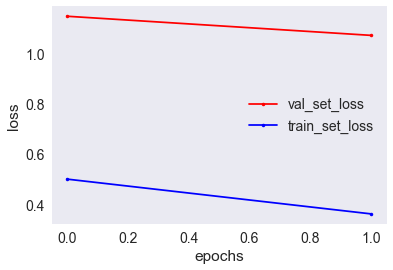

In [15]:
# loss : 훈련 손실값
# acc : 훈련 정확도
# val_loss : 검증 손실값
# val_acc : 검증 정확도

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


# 2차원 그래프 그리기
plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')

# 라벨 설정
plt.legend()

# x축
plt.xlabel('epochs')
# y축
plt.ylabel('loss')

# 그래프 x y축 선 그리기
plt.grid()
plt.show()

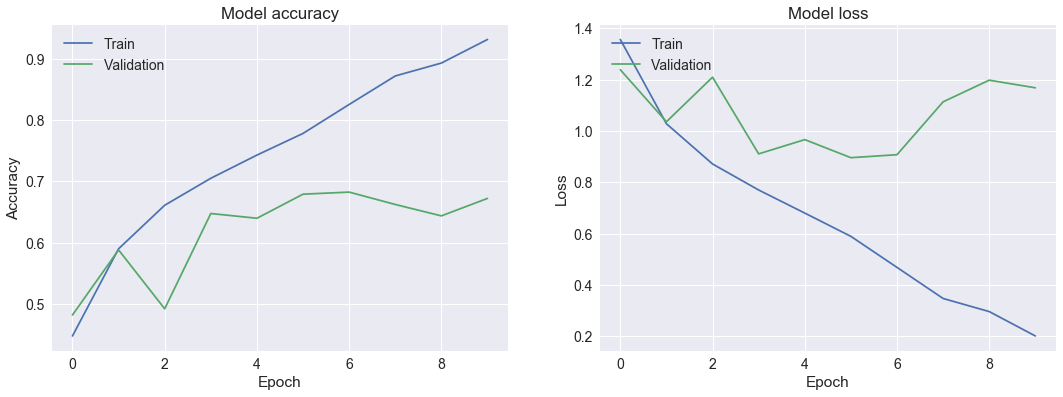

In [12]:
# 에포크 마다의 훈련 손실값 (loss)
# 에포크 마다의 훈련 정확도 (acc)
# 에포크 마다의 검증 손실값 (val_loss)
# 에포크 마다의 검증 정확도 (val_acc)

# 그래프로 표시한다면 학습 상태를 직관적으로 볼 수 있다.
# matplotlib 패키지를 이용하면 하나의 그래프로 쉽게 표시할 수 있다.

fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
print(history.history)

{'val_loss': [1.2385741832845867, 1.0356832209439508, 1.2094226943057858, 0.9104400968170535, 0.966045133013447, 0.8955765452121355, 0.9072560067181438, 1.1133877978714075, 1.1978522169442753, 1.1680787321614077], 'val_accuracy': [0.48159360885620117, 0.5880358219146729, 0.491765558719635, 0.6474933624267578, 0.6397432684898376, 0.6790990829467773, 0.6824896931648254, 0.6622669100761414, 0.6436182856559753, 0.6721966862678528], 'loss': [1.3565625410028752, 1.0279945463855287, 0.8711377432376085, 0.7696215963484921, 0.6796598969593088, 0.5888179124645662, 0.4678598634071823, 0.34659413755563245, 0.2955665113630353, 0.20044457231482876], 'accuracy': [0.44733763, 0.58980256, 0.6609745, 0.7050987, 0.7429656, 0.77841026, 0.82572365, 0.87231034, 0.89342374, 0.9319769]}
